## Sentiment Anlysis of Tweets: Natural Language Processing with TensorFlow

---

Dataset: [Tweet sentiment Dataset](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset)

---

## Setup and Imports

1. Installing unidecode library
2. Importing libraries

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 8.0 MB/s eta 0:00:00


In [15]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import random
import string
from google.colab import drive
drive.mount('/content/drive')

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.losses import SparseCategoricalCrossentropy

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from unidecode import unidecode

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading Data

1. Importing the Tweet Emotion dataset from https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset
2. Dropping nulls
3. Creating train, validation and test sets(60/20/20)

In [3]:
dataset = pd.read_csv("drive/MyDrive/Dataset/Twitter_Data.csv")
dataset = dataset.dropna()

In [4]:
train, validate, test = np.split(dataset.sample(frac=1, random_state=42), [int(.6*len(dataset)), int(.8*len(dataset))])

In [5]:
x_train = train['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
y_train = train['category'].astype(int)
x_val = validate['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
y_val = validate['category'].astype(int)
x_test = test['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
y_test = test['category'].astype(int)

## Cleaning, Lemmatizing and Tokenizing the tweets

1. Removing stop words
2. Lemmatizing the tweets
3. Tokenizing the tweets

In [6]:
lemmatizer = WordNetLemmatizer()

#removing english stopwords, lemmatizing words
def lemmitize(article):
  stopset = stopwords.words('english') + list(string.punctuation)
  article = " ".join([i for i in word_tokenize(article) if i not in stopset])
  article = unidecode(article)
  words = word_tokenize(article)
  s = []
  for word in words:
      s.append(lemmatizer.lemmatize(word))
  article = " ".join(s)
  return article
  
lemmitize("Sample of non ASCII: Ceñía. How to remove stopwords and punctuations feet?")

'Sample non ASCII Cenia How remove stopwords punctuation foot'

In [7]:
x_train = x_train.apply(lemmitize)
x_val = x_val.apply(lemmitize)
x_test = x_test.apply(lemmitize)

In [8]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [9]:
#creating tokenizer
tokenizer = Tokenizer (num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='<UNK>', document_count=0)

In [10]:
#Tokenizing the tweets
tokenizer.fit_on_texts(x_train)
x_train_token=tokenizer.texts_to_sequences(x_train)

vocab_size = len(tokenizer.word_index)+1

x_val_token=tokenizer.texts_to_sequences(x_val)
x_test_token=tokenizer.texts_to_sequences(x_test)

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

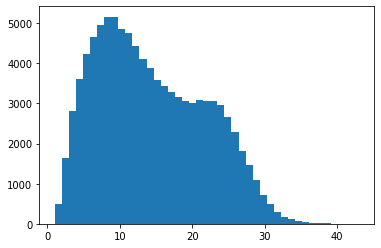

(None, 43)

In [11]:
lengths = [len(t.split(' ')) for t in x_train]
plt.hist(lengths, bins = len(set(lengths)))
plt.show(), max(lengths)

In [16]:
maxlen = 45

x_train = sequence.pad_sequences(x_train_token, maxlen=maxlen, truncating='post', padding='post')
x_val = sequence.pad_sequences(x_val_token, maxlen=maxlen, truncating='post', padding='post')
x_test = sequence.pad_sequences(x_test_token, maxlen=maxlen, truncating='post', padding='post')

print('x_train shape:', np.array(x_train).shape)
print('x_val shape:', np.array(x_val).shape)
print('x_test shape:', np.array(x_test).shape)

x_train shape: (97781, 45)
x_val shape: (32594, 45)
x_test shape: (32594, 45)


## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
#checking labels distribution
plt.hist(dataset['category'], label=set(dataset['category']))
plt.xticks(list(set(dataset['category'])))
plt.show()

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

y_train shape: (97781,)
y_val shape: (32594,)
y_test shape: (32594,)


In [18]:
# #changing labels to categorical
# import keras
# y_train_l = keras.utils.to_categorical(y_train, 3)
# y_val_l = keras.utils.to_categorical(y_val, 3)
# y_test_l = keras.utils.to_categorical(y_test, 3)

In [19]:
#when you have non numeric labels
class_to_index = dict((c,i) for i,c in enumerate(set(y_train)))
index_to_class = dict((i,c) for c,i in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
y_train_l = names_to_ids(y_train)
y_val_l = names_to_ids(y_val)
y_test_l = names_to_ids(y_test)

## Creating & Compiling the Model

1. Creating the model
2. Compiling the model

In [20]:
model = tf.keras.models.Sequential(layers=[
    Embedding(vocab_size, 16 , input_length=maxlen),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20)),
    Dense(3, activation='softmax')

])

model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', 
                metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            1111072   
                                                                 
 bidirectional (Bidirectiona  (None, 45, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 123       
                                                                 
Total params: 1,126,875
Trainable params: 1,126,875
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [22]:
h = model.fit(x_train, y_train_l, validation_data = (x_val, y_val_l), epochs = 20, callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/20
3056/3056 [==============================] - 254s 80ms/step - loss: 0.4662 - accuracy: 0.8269 - val_loss: 0.3418 - val_accuracy: 0.8932
Epoch 2/20
3056/3056 [==============================] - 247s 81ms/step - loss: 0.2695 - accuracy: 0.9150 - val_loss: 0.3142 - val_accuracy: 0.9020
Epoch 3/20
3056/3056 [==============================] - 253s 83ms/step - loss: 0.2114 - accuracy: 0.9345 - val_loss: 0.3452 - val_accuracy: 0.8940
Epoch 4/20
3056/3056 [==============================] - 255s 84ms/step - loss: 0.1649 - accuracy: 0.9497 - val_loss: 0.3760 - val_accuracy: 0.8870
Epoch 5/20
3056/3056 [==============================] - 253s 83ms/step - loss: 0.1282 - accuracy: 0.9599 - val_loss: 0.4650 - val_accuracy: 0.8675


## Evaluating the Model

1. Visualizing training history
2. Evaluating trained model on test set
3. Plotting confusion matrix for test set

In [37]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


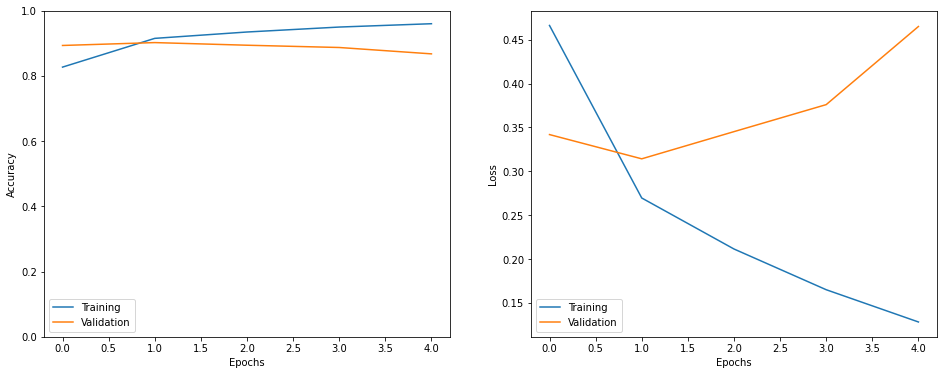

In [38]:
show_history(h)

In [39]:
model.evaluate(x_test, y_test_l)

1019/1019 [==============================] - 15s 15ms/step - loss: 0.4632 - accuracy: 0.8689


[0.4632229804992676, 0.8689022660255432]

In [40]:
#checking random prediction
idx= random.randint(0, len(x_test)-1)

print('Test tweet: ', x_test[idx])
print('Actual label: ', y_test[idx])

pred = model.predict(np.expand_dims(x_test[idx], axis=0))[0]
pred_label = index_to_class[np.argmax(pred).astype('int')]

print('Predicted label: ', pred_label)

Test tweet:  [    9    19    11   242   312  4471  2622   312 22585  2622 10126  1160
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]
Actual label:  0
1/1 [==============================] - 2s 2s/step
Predicted label:  0


In [41]:
y_pred = model.predict(x_test)
classes_y =np.argmax(y_pred,axis=1)

1019/1019 [==============================] - 18s 18ms/step


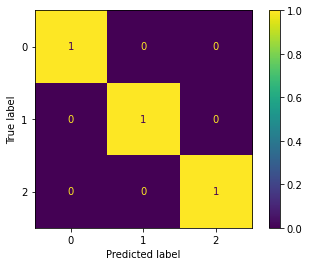

In [42]:
# plot confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels= list(set(y_test_l)))
disp.plot()
plt.show()